In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import xlrd
import os
import fiona
from statistics import mean, median
import string
import math
import re

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# VEST NE 2018

## VEST Documentation

### Sources

Election results from the Nebraska Secretary of State's office via email.

### Shapefiles

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. 

Adams, Antelope, Box Butte, Buffalo, Burt, Butler, Chase, Cherry, Cuming, Custer, Dakota, Dawes, Dawson, Deuel, Dodge, Douglas, Garfield, Hamilton, Harlan, Holt, Kearney, Keith, Keya Paha, Kimball, Lincoln, Madison, Merrick, Morrill, Nemaha, Nuckolls, Otoe, Perkins, Phelps, Platte, Red Willow, Richardson, Saline, Sarpy, Scotts Bluff, Seward, Stanton, Thayer, Valley, and Washington either used a replacement shapefile or, more often, required tweaks based on PDF maps from county election officials and the geocoded voter registration file.

Some counties reported one or more classes of votes at the county level. These were distributed by candidate based on the precinct-level reported vote.

### Races

G18USSRFIS - Deb Fischer (Republican Party)<br>
G18USSDRAY - Jane Raybould (Democratic Party)<br>
G18USSLSCH - Jim Schultz (Libertarian Party)<br>
<br>
G18GOVRRIC - Pete Ricketts (Republican Party)<br>
G18GOVDKRI - Bob Krist (Democratic Party)<br>
<br>
G18SOSREVN - Bob Evnen (Republican Party)<br>
G18SOSDDAN - Spencer Danner (Democratic Party)<br>
<br>
G18TRERMUR - John Murante (Republican Party)<br>
<br>
G18ATGRPET - Doug Peterson (Republican Party)<br>
<br>
G18AUDRJAN - Charlie Janssen (Republican Party)<br>
G18AUDDSKI - Jane Skinner (Democratic Party)<br>

## Load in VEST file

In [2]:
vest_ne_2018 = gp.read_file("./raw-from-source/VEST/ne_2018/ne_2018.shp")

<AxesSubplot:>

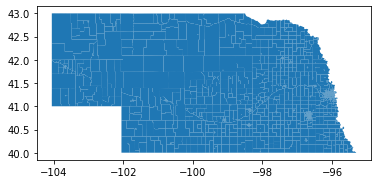

In [3]:
vest_ne_2018.plot()

## Build table of precinct-level election results from NE SOS Spreadsheets

The 2018 election results provided by NE SOS are designed for human legibility, not algorithmic use. They need to be cleaned, transformed, and reformatted to be usable here; this section outlines that process.

Notes for parsing NE SOS's Excel files:
- Each county's excel document contains many races separated by whitespace rows.
- Ignore column B; it only contains the name of the county (which we have from the filename). In the vote tables, it's just an unnecessary blank column.
- When the county spreadsheets are loaded in as dataframes, their default column headings are not descriptive. To make this easier to follow, we assign alphabetical column names that align with Excel's typical column naming conventions (Column 1 = "A", Column 2 = "B", etc.)

In [4]:
# Returns the letter at position 'num' in the English alphabet. A=1, B=2, ..., Z=26. 
def num_to_letter(num):
    return chr(ord('@') + num)

# Returns a cleaned NE 2018 county spreadsheet as a dataframe. 
# This function renames each column from its default value of "Unnamed: i" to the i+1th letter in the English alphabet. 
# Column B is removed because it contains no meaningful information, and every blank row is removed as well. 
#
# Each of these sheets contains the results of every race that happened in 2018 within the county. 
def load_county_excel_sheet(path_to_file):
    county_xls = pd.read_excel(path_to_file, skiprows=1)
    cols = list(map(lambda e: num_to_letter(e), range(1, len(county_xls.columns)+1)))
    county_xls.columns = cols
    cols.remove('B')
    county_xls = county_xls[cols]
    county_xls = county_xls.dropna(how='all')
    county_xls = county_xls.reset_index(drop=True)
    return county_xls.copy(deep=True)

In order to separate the tables for different races in each county's spreadsheet, we need to detect where each table starts and ends. Each table starts with a row that contains something close to an office/race label (e.g., "For United States Senator"), and each table ends with a row that contains the total number of votes for each office. Throughout this section, we'll refer to the rows that contain office/race values as "office rows", and the row w/ vote totals as "total rows". 

These rows have distinguishing features that we can search for to find their locations (i.e., row numbers) in each county's spreadsheet:

`office_rows = county_xls[(county_xls['A'] == 'Precinct Name') & (~county_xls['C'].isnull())]`<br>
`total_rows = county_xls[county_xls['A'] == 'Total']`

In the code below, we use these key rows to detect the height of each table.

In [5]:
# Attempts to find the boundaries of each subtable in a county spreadsheet by looking for rows containing
# office/race information, and by looking for "total" rows. 
#
# Returns a list of tuples (s, t), one per subtable detected in county_xls. 
# s = the starting row # of the subtable
# t = the ending row # of the subtable. 
#
# This function expects that the `county_xls` dataframe has been cleaned and prepared in the 
# manner performed by the load_county_excel_sheet() function. 
#
# Raises a ValueException if there's a problem detecting boundaries. 
def detect_table_boundaries(county_xls):
    office_indices = list(county_xls[(county_xls['A'] == 'Precinct Name') & (~county_xls['C'].isnull())].index)
    total_indices = list(county_xls[county_xls['A'] == 'Total'].index)
    table_boundary_pairs = list(zip(office_indices, total_indices))
    
    # check that there are an equal number of "office" rows and total rows. 
    # If not, file is malformed and data must be extracted manually.
    if len(office_indices) != len(total_indices):
        raise ValueException('Number of office rows {0} != number of total rows {1}.'.format(len(office_indices), len(total_indices)))

    # check that there is no distance between each table. Since we've removed whitespace, distance likely means that
    # our table separation routine failed and the races will have to be separated manually.  
    for idx, pair in enumerate(table_boundary_pairs):
        if idx != len(table_boundary_pairs)-1:
            pair_next = table_boundary_pairs[idx+1]
            if pair_next[0] - pair[1] != 1:
                raise ValueException('Table boundary error detected. "Total" at row # {0}, Next "office" row at {1}'.format(pair[1], pair_next[0]))
    
    return table_boundary_pairs

The row below each "office row" is a row that we'll refer to as a "candidate row". It contains each of the candidates that are running in the race summarized by a subtable. 

This code extracts the candidate's names from a "candidate row". It removes unnecessary party affiliations, formatting characters, and gratuitous whitespace from each cell, and it returns each candidate's name as a list. It also ignores the rightmost "Total" column because we're about to remove that column entirely; keeping it just makes things more complicated, and we can always re-calculate that column later if we need it.

In [6]:
# Cleans an excel row that contains candidate information for a sub-table in a 2018 county spreadsheet
# and returns a list of the candidates.
def extract_candidates_from_row(r):
    # eliminate NaN values and the total row. 
    l = list(filter(lambda e: not pd.isna(e), r))
    raw_candidates = list(filter(lambda e: e != 'Total', l))
    
    # partisan candidate names and their parties are delimited by newlines. 
    candidate_names = list(map(lambda e: e.split('\n')[0].strip(), raw_candidates))
    return candidate_names

We only need to keep precinct data for six statewide races. We'll map the the value found in each relevant table's "office row" to a simpler label that we can use as a reliable filename suffix.

In [7]:
offices_standardized = {
    'For United States Senator -': 'Senate',
    'For Governor and Lt. Governor -': 'Governor',
    'For Secretary of State': 'SOS',
    'For State Treasurer': 'Treasurer',
    'For Attorney General': 'AG',
    'For Auditor of Public Accounts': 'Auditor'
}

By combining all of the functions above, we can separate the subtables from each county's spreadsheet, and throw out everything else we don't care about (which is all but the six races outlined above). 

In [8]:
# county_xls dataframe should be cleaned and formatted; 
# use the load_county_excel_sheet() function to do this automatically.
def extract_races_from_excel(county_xls, county_name):
    race_tables = {}
    try: 
        # detect table boundaries if possible.
        tb_pairs = detect_table_boundaries(county_xls)
        for office_idx, end_idx in tb_pairs:
            # get the name of the office this table relates to and standardize it if it's a race we care about.
            # if we don't recognize the office, don't bother storing it; we don't need it. 
            office_val = county_xls.at[office_idx, 'C'].strip()
            if office_val in list(offices_standardized.keys()):
                office_val = offices_standardized[office_val]
                
                # get the list of candidates from the next row
                candidates = extract_candidates_from_row(county_xls.loc[office_idx+1])

                # Race tables conform to this format:  
                # | Precinct Name | Candidate 1's total votes | ... | Last candidate's total votes | Total |
                #
                # The dimensions of this race table may be smaller than the full sheet, but since they're 
                # dependant on the total number of candidates in the race, they're simple to detect.  
                column_count = 1 + len(candidates)

                # Not intuitive because we have to map numbers to column letters, but this builds a list 
                # of the appropriate letters so we can select the columns with votes for all candidates in this race.
                # 'C' = column label with first candidate, 'D' = second, and so on. 
                # (It's hard to skip column B using a range expression, so I just stick it on later.) 
                vote_columns = list(map(lambda e: num_to_letter(e), range(3, (3+len(candidates)))))
                vote_columns = ['A'] + vote_columns

                # store only the precinct rows related to this race, and add candidate names to the header. 
                race_table = county_xls[vote_columns].loc[(office_idx+2):(end_idx-1)].copy(deep=True)
                race_table.columns = ['Precinct'] + candidates
                race_tables[office_val] = race_table
    except ValueError as e:
        print('Error when extracting races from {0} from county: {1}'.format(county_name, e))
    return race_tables

### Perform the Full Cleaning/Separation Process

We'll generate six subtables with precinct results from each county, one for each office we care about. To maintain organization, we're storing each of these subtables in a separate directory that corresponds with the name of the office the data refers to. 

In [9]:
# If this is true, the cells in this section will clean, process, and re-join the election data provided by NE SOS 
# to create a single file which contains the 2018 election results for all six statewide offices.
# These races in 2018 were the elections for US Senate, Governor, Treasurer, Auditor, Attorney General, 
# and Secretary of State. 
#
# By default, this file is called "2018-statewide-results-by-pcnt.csv", and it will be written to the path 
# defined in OUTPUT_DIR in the cell below. 
#
# A cached version of this file is distributed with the source data for this notebook, 
# but you can use this variable to build the file yourself if you'd prefer. 
SHOULD_PROCESS_INPUT_DATA = False

In [10]:
INPUT_DIR = './raw-from-source/Election_Results/General-18-Precinct-Results/'
OUTPUT_DIR = './raw-from-source/Election_Results/processed-g18-results/'

# Stores a 2018 subtable (or race table) in its appropriate directory (determined by office) 
# and applies the office name to the output filename as a suffix. 
# 
# Files saved with this function follows this structure: 
# ../raw-from-source/2018-er/processed-g18-results/{office}/{countyname_officename}.csv
def write_race_table(df, office_name, county_name):
    output_filename = '{0}_{1}.csv'.format(county_name, office_name)
    output_dir = os.path.join(OUTPUT_DIR, office_name)
    output_fp = os.path.join(output_dir, output_filename)
    df.to_csv(output_fp, index=False)
    print("wrote {0} rows to {1}".format(len(df), output_fp))

all_tables = {}    
input_files = os.listdir(INPUT_DIR)

if SHOULD_PROCESS_INPUT_DATA:
    for fn in list(filter(lambda e: e.endswith('.xls'), input_files)):
        county_name = fn.split('.xls')[0]
        input_fp = os.path.join(INPUT_DIR, fn)

        # load and clean input sheet, extract the tables from each race from this county's spreadsheet. 
        county_xls = load_county_excel_sheet(input_fp)
        race_tables = extract_races_from_excel(county_xls, county_name)

        # save each extracted table to disk
        for office_name in race_tables.keys():
            pcnt_table = race_tables[office_name]
            write_race_table(pcnt_table, office_name, county_name)
        all_tables[county_name] = race_tables 

Here we join all of the counties and races together, change the candidate's names to VEST identifiers, and write the whole thing to disk to build one file of statewide race data by precinct. 

In [11]:
# Bring all of the data together, change candidate's names to VEST's race identifiers

INPUT_DIR = './raw-from-source/Election_Results/processed-g18-results/'

candidate_to_vest_id = {
    'Deb Fischer': 'G18USSRFIS',
    'Jane Raybould': 'G18USSDRAY',
    'Jim Schultz': 'G18USSLSCH',
    'Pete Ricketts Mike Foley and': 'G18GOVRRIC',
    'Bob Krist Lynne M. Walz and': 'G18GOVDKRI',
    'Bob Evnen': 'G18SOSREVN',
    'Spencer Danner': 'G18SOSDDAN',
    'John Murante': 'G18TRERMUR',
    'Doug Peterson': 'G18ATGRPET',
    'Charlie Janssen': 'G18AUDRJAN',
    'Jane Skinner': 'G18AUDDSKI'
}

county_tables = {}

counties = list(all_tables.keys())
counties.sort()
offices = offices_standardized.values()

if SHOULD_PROCESS_INPUT_DATA:
    for county in counties: 
        county_race_tables = {}
        for office in offices:
            target_filename = '{0}_{1}.csv'.format(county, office)
            target_fp = os.path.join(INPUT_DIR, office, target_filename)
            race_df = pd.read_csv(target_fp)

            # replace each candidate's name with their VEST identifier
            candidates = list(race_df.columns)[1:]
            vest_headings = list(map(lambda e: candidate_to_vest_id[e], candidates))
            race_df.columns = ['Precinct'] + vest_headings
            county_race_tables[office] = race_df

        # using the senate race as a base, join each additional race table together to create a single table for this county. 
        county_df = county_race_tables['Senate']
        other_races = list(county_race_tables.keys())
        other_races.remove('Senate')
        for office in other_races:
            next_df = county_race_tables[office]
            county_df = county_df.merge(next_df, how='outer', on='Precinct').copy(deep=True)

        # write the full county table to disk 
        target_filename = '{0}.csv'.format(county)
        output_fp = os.path.join(INPUT_DIR, 'Combined', target_filename)
        county_df.to_csv(output_fp, index=False)

        # add an explicit County column and store it so we can build the full statewide results table later.
        county_df['County'] = county
        county_tables[county] = county_df

    # finally, we build one final file that combines every county's election results.
    statewide_df = pd.concat(county_tables.values(), axis=0)
    cols = ['County', 'Precinct'] + list(candidate_to_vest_id.values())
    statewide_df = statewide_df[cols]

    # check for NaNs in the final table which would indicate a problem during joining
    for c in cols:
        s = statewide_df[c]
        if pd.isnull(s).any():
            print('NAN found in column {0}!'.format(c))

    # write the full table if it looks good. 
    target_filename = '2018-statewide-results-by-pcnt.csv'
    output_fp = os.path.join(INPUT_DIR, target_filename)
    statewide_df.to_csv(output_fp, index=False)

### Load in Raw Election Results

NOTE: This is just the file we created in the "Build table of precinct-level election results from NE SOS Spreadsheets" section above. 

In [12]:
er_2018_df = pd.read_csv('./raw-from-source/Election_Results/processed-g18-results/2018-statewide-results-by-pcnt.csv')

### Validate statewide totals

In [13]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [14]:
races = list(candidate_to_vest_id.values())
statewide_totals_check(vest_ne_2018, er_2018_df, races)

***Statewide Totals Check***
G18USSRFIS is equal 	VEST / RDH: 403151
G18USSDRAY is equal 	VEST / RDH: 269917
G18USSLSCH is equal 	VEST / RDH: 25349
G18GOVRRIC is equal 	VEST / RDH: 411812
G18GOVDKRI is equal 	VEST / RDH: 286169
G18SOSREVN is equal 	VEST / RDH: 406632
G18SOSDDAN is equal 	VEST / RDH: 263982
G18TRERMUR is equal 	VEST / RDH: 516210
G18ATGRPET is equal 	VEST / RDH: 516777
G18AUDRJAN is equal 	VEST / RDH: 380666
G18AUDDSKI is equal 	VEST / RDH: 280669


### Validate county totals

Convert 'County' column on our results to a FIPS column.

In [15]:
fips_df = pd.read_csv('./raw-from-source/FIPS/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 31]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_dict = dict(zip(fl['County Name'], fl['FIPS County']))
er_2018_df['FIPS'] = er_2018_df['County'].apply(lambda e: str(fips_dict[e]).zfill(3)).copy()
er_2018_df = er_2018_df[(['FIPS', 'Precinct'] + races)]
er_2018_df = er_2018_df.rename(columns={'FIPS':'COUNTY', 'Precinct': 'NAME'})
ne_2018_df = er_2018_df[(['COUNTY', 'NAME'] + races)]

In [16]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [17]:
# VEST's county and precinct name columns are "COUNTYFP" and "NAMELSAD", respectively. 
# Temporarily change the columns of the source data table to match these so we can compare county totals. 
ne_2018_4cv = ne_2018_df.copy(deep=True)
ne_2018_4cv = ne_2018_4cv.rename(columns={'COUNTY': 'COUNTYFP', 'NAME': 'NAMELSAD'})
county_totals_check(vest_ne_2018, ne_2018_4cv, races, 'COUNTYFP', full_print=False)

***Countywide Totals Check***

G18USSRFIS is equal across all counties
G18USSDRAY is equal across all counties
G18USSLSCH is equal across all counties
G18GOVRRIC is equal across all counties
G18GOVDKRI is equal across all counties
G18SOSREVN is equal across all counties
G18SOSDDAN is equal across all counties
G18TRERMUR is equal across all counties
G18ATGRPET is equal across all counties
G18AUDRJAN is equal across all counties
G18AUDDSKI is equal across all counties


## Absentee Allocation

Do basic standardization of precinct names before allocating absentee votes. 

In [18]:
# transform the precinct name column in both data sets to all uppercase
ne_2018_df['NAME'] = ne_2018_df['NAME'].apply(lambda e: e.upper())
vest_ne_2018['NAMELSAD'] = vest_ne_2018['NAMELSAD'].apply(lambda e: e.upper())

Remove precincts from the source data set that contain votes that need to be re-allocated. In this data set, absentee votes are labeled in one of two ways:

- `(COUNTYWIDE) ABSENTEE/EARLY VOTE`
- `COUNTYWIDE`

In [19]:
to_allocate_df = ne_2018_df[ne_2018_df['NAME'].str.contains('COUNTYWIDE')].copy(deep=True)
ne_2018_df = ne_2018_df.loc[~(ne_2018_df['NAME']).str.contains('COUNTYWIDE')]

Some counties have multiple groups of votes that need to be allocated (e.g., N votes labeled as `COUNTYWIDE`, and M votes labeled as `(COUNTYWIDE) ABSENTEE/EARLY VOTE`). Since there's no real reason to keep these separated, we'll combine all of the absentee votes within a county together under one `"ABSENTEE"` label.

In [20]:
race_cols = list(candidate_to_vest_id.values())
to_allocate_df = to_allocate_df.groupby('COUNTY').sum(race_cols).copy(deep=True)
to_allocate_df['NAME'] = 'ABSENTEE'
to_allocate_df = to_allocate_df[['NAME'] + race_cols]

In [21]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

Perform absentee vote allocation. 

In [22]:
ne_2018_df = allocate_absentee(ne_2018_df, to_allocate_df, race_cols, 'COUNTY')

### Merge Source Results onto VEST

Assign unique ID to each row in both data sets by joining the county and precinct name together. 

In [23]:
vest_ne_2018['unique_ID'] = vest_ne_2018['COUNTYFP'] + '-' + vest_ne_2018['NAMELSAD']
ne_2018_df['unique_ID'] = ne_2018_df['COUNTY'] + '-' + ne_2018_df['NAME']

In order to join the Secretary of State's results with VEST's, it is desirable to define a one-to-one relationship between the set of source precincts and the set of VEST precincts. 

There are two cases where the results of more than one precinct in NE SOS's results are combined and referenced as a single precinct in VEST's results; both of these occur in Custer County. 

| Source Precinct UIDs              | VEST Precinct UID                   | 
|:----------------------------------|:------------------------------------|
| `041-CORNER`, `041-SARGENT RURAL` | `041-CORNER/RURAL SARGENT PRECINCT` | 
| `041-MILBURN`, `041-LILLIAN`      | `041-LILLIAN/MILBURN PRECINCT`      |

We'll combine these precincts in the source data before performing the merge so that we can correctly compare their vote totals. 

In [24]:
# Merges rows within a set of precinct results. 
# 
# pcnts_to_merge: List of names/identifiers of rows to be merged.  
# pcnt_col_name: Name of the column that contains the values in 'pcnts_to_merge'. 
# race_cols: List of columns that contain vote counts that need to be combined (i.e. additively). 
# 
# It is assumed that all non-race columns will have *identical values* in each row to be merged, 
# and substitute them back into the merged row. If that's a problem, don't use this function!
#
# new_pcnt_name: Desired name/identifier of the newly merged precinct. 
# Will be written in the 'pcnt_col_name' column of the returned series. 
#
# Returns the newly merged row.
def merge_precincts(df, pcnts_to_merge, pcnt_col_name, race_cols, new_pcnt_name):
    race_totals = df.loc[df[pcnt_col_name].isin(pcnts_to_merge)].sum()[race_cols]
    non_race_cols = df[list(filter(lambda e: e not in race_cols, df.columns))].to_dict('records')[0]
    new_row = {k:v for d in (non_race_cols, race_totals) for k, v in d.items()}
    new_row[pcnt_col_name] = new_pcnt_name
    return pd.Series(new_row)

race_cols = list(candidate_to_vest_id.values())

# Merge 041-CORNER & 041-SARGENT RURAL 
target_rows = ne_2018_df.loc[ne_2018_df['unique_ID'].isin(['041-CORNER', '041-SARGENT RURAL'])].copy(deep=True)
m1 = merge_precincts(target_rows, ['041-CORNER', '041-SARGENT RURAL'], 'unique_ID', race_cols, '041-CORNER/RURAL SARGENT PRECINCT')
m1['NAME'] = 'CORNER/RURAL SARGENT PRECINCT'
ne_2018_df = ne_2018_df.append(m1, ignore_index=True)
ne_2018_df = ne_2018_df.loc[~(ne_2018_df['unique_ID'].isin(list(target_rows['unique_ID'])))]

# Merge 041-MILBURN & 041-LILLIAN
target_rows = ne_2018_df.loc[ne_2018_df['unique_ID'].isin(['041-MILBURN', '041-LILLIAN'])].copy(deep=True)
m2 = merge_precincts(target_rows, ['041-MILBURN', '041-LILLIAN'], 'unique_ID', race_cols, '041-LILLIAN/MILBURN PRECINCT')
m2['NAME'] = 'LILLIAN/MILBURN PRECINCT'
ne_2018_df = ne_2018_df.append(m2, ignore_index=True)
ne_2018_df = ne_2018_df.loc[~(ne_2018_df['unique_ID'].isin(list(target_rows['unique_ID'])))]


In [25]:
merge_1_df = pd.merge(vest_ne_2018, ne_2018_df, how='outer', on='unique_ID', indicator=True, validate='1:1').copy(deep=True)

# Compare the number of rows with NaN values (failed joins) against the number without any (successful joins). 
nan_rows = merge_1_df[merge_1_df.isnull().any(axis=1)]
valid_rows = merge_1_df[~merge_1_df.isnull().any(axis=1)]
print(merge_1_df['_merge'].value_counts())

left_only     1052
right_only    1052
both           335
Name: _merge, dtype: int64


In [26]:
merge_1_df.loc[merge_1_df['_merge'] == 'left_only'].to_csv('./vest-only.csv', index=False)
merge_1_df.loc[merge_1_df['_merge'] == 'right_only'].to_csv('./src-only.csv', index=False)
merge_1_df.loc[merge_1_df['_merge'] == 'both'].to_csv('./merged-only.csv', index=False)

Apply the source precinct -> VEST precinct ID mapping

In [27]:
nan = np.nan
s2v = {'001-3-D': '001-3D', '001-4-C': '001-4C', '001-4-E': '001-4E', '001-2-A': '001-2A', '001-4-A': '001-4A', '001-3-B': '001-3B', '001-4-B': '001-4B', '001-1-C': '001-1C', '001-WESTBLUE/HIGHLAND': '001-HIGHLAND_WEST_BLUE', '001-1-B': '001-1B', '001-3-A': '001-3A', '001-3-C': '001-3C', '001-2-C': '001-2C', '001-2-E': '001-2E', '001-JUNIATA': '001-JUNIATA PRECINCT', '001-2-B': '001-2B', '001-1-A': '001-1A', '001-4-D': '001-4D', '001-2-D': '001-2D', '001-3-E': '001-3E', '003-NELIGH 2ND WARD': '003-NELIGH CITY 2ND WARD', '003-NELIGH 1ST WARD': '003-NELIGH CITY 1ST WARD', '005-ARTHUR': '005-ARTHUR PRECINCT', '007-LONG SPRINGS': '007-LONG SPRINGS PRECINCT', '009-BLAINE': '009-BLAINE PRECINCT', '011-NORTH BRANCH-SHELL CREEK': '011-NORTH BRANCH-SHELL CREEK PRECINCT', '011-DUBLIN-BONANZA': '011-DUBLIN-BONANZA PRECINCT', '011-BOONE': '011-BOONE PRECINCT', '011-NORTH MANCHESTER': '011-NORTH MANCHESTER PRECINCT', '011-CEDAR': '011-CEDER PRECINCT', '011-SOUTHWEST MANCHESTER': '011-SOUTHWEST MANCHESTER PRECINCT', '011-BEAVER': '011-BEAVER PRECINCT', '011-SOUTHEAST MANCHESTER': '011-SOUTHEAST MANCHESTER PRECINCT', '011-OAKLAND': '011-OAKLAND PRECINCT', '013-PRECINCT 12': '013-VOTING PRECINCT 12', '013-PRECINCT 11': '013-VOTING PRECINCT 11', '013-PRECINCT 3': '013-VOTING PRECINCT 3', '013-PRECINCT 1': '013-VOTING PRECINCT 1', '013-PRECINCT 2': '013-VOTING PRECINCT 2', '013-PRECINCT 4': '013-VOTING PRECINCT 4', '013-PRECINCT 6': '013-VOTING PRECINCT 6', '013-PRECINCT 5': '013-VOTING PRECINCT 5', '013-PRECINCT 15': '013-VOTING PRECINCT 15', '015-LYNCH BRISTOW MULLEN BUSH': '015-BRISTOW - MULLEN - LYNCH - BUSH PRECINCT', '015-BUTTE BASIN MCCULLEY': '015-BASIN - MCCULLEY - BUTTE PRECINCT', '015-SPENCER MORTON': '015-SPENCER - MORTON PRECINCT', '017-THE PINES': '017-PINES PRECINCT', '017-CITY OF AINSWORTH': '017-CITY OF AINSWORTH PRECINCT', '019-PRECINCT 7': '019-PRECINT 7', '021-CRAIG': '021-CRAIG PRECINCT', '021-EVERETT-LOGAN': '021-EVERETT-LOGAN PRECINCT', '021-SILVERCREEK-SUMMIT': '021-SILVER CREEK-SUMMIT PRECINCT', '021-DECATUR-QUINN': '021-DECATUR-QUINBAUGH PRECINCT', '021-BELL-OAK-PERSH': '021-BELLCREEK-OAKLAND-PERSHING PRECINCT', '021-TEKAMAH I': '021-TEKAMAH 1', '021-TEKAMAH II': '021-TEKAMAH 2', '021-LYONS CITY': '021-LYONS PRECINCT', '021-OAKLAND II': '021-OAKLAND CITY 2', '021-OAKLAND I': '021-OAKLAND CITY 1', '023-READ-ULYSSES': '023-READ-ULYSSES PRECINCT', '023-UNION-OLIVE': '023-UNION-OLIVE PRECINCT', '023-FRANKLIN-BONE CREEK': '023-FRANKLIN-BONE CREEK PRECINCT', '023-FIRST WARD': '023-DAVID CITY WARD 1', '023-LINWOOD-SKULL CREEK-PLATTE': '023-LINWOOD-SKULL CREEK - PLATTE PRECINCT', '023-SUMMIT-READING': '023-SUMMIT-READING PRECINCT', '023-PLUM CREEK-RICHARDSON': '023-PLUM CREEK-RICHARDSON PRECINCT', '023-OAK CREEK-CENTER': '023-OAK CREEK-CENTER PRECINCT', '023-SECOND WARD': '023-DAVID CITY WARD 2', '023-THIRD WARD': '023-DAVID CITY WARD 3', '023-SAVANNAH-ALEXIS': '023-SAVANNAH-ALEXIS PRECINCT', '025-MOUNT PLEASANT': '025-MOUNT_PLEASANT', '025-4TH WARD - 1ST PRECINCT': '025-PLATTSMOUTH_4_WARD_1_PRECINCT', '025-WEEPING WATER 2ND WARD': '025-WEEPING_WATER_WARD_2', '025-WEEPING WATER 1ST WARD': '025-WEEPING_WATER_WARD_1', '025-2ND WARD - 2ND PRECINCT': '025-PLATTSMOUTH_2_WARD_2_PRECINCT', '025-3RD WARD - 2ND PRECINCT': '025-PLATTSMOUTH_3_WARD_2_PRECINCT', '025-1ST WARD - 2ND PRECINCT': '025-PLATTSMOUTH_1_WARD_2_PRECINCT', '025-1ST WARD - 1ST PRECINCT': '025-PLATTSMOUTH_1_WARD_1_PRECINCT', '025-4TH WARD - 2ND PRECINCT': '025-PLATTSMOUTH_4_WARD_2_PRECINCT', '025-3RD WARD - 1ST PRECINCT': '025-PLATTSMOUTH_3_WARD_1_PRECINCT', '025-2ND WARD - 1ST PRECINCT': '025-PLATTSMOUTH_2_WARD_1_PRECINCT', '025-WEST ROCK BLUFF': '025-WEST_ROCK_BLUFF', '025-SALT CREEK': '025-SALT_CREEK', '025-EAST LOUISVILLE': '025-EAST_LOUISVILLE', '025-STOVE CREEK': '025-STOVE_CREEK', '025-NORTH ROCK BLUFF': '025-NORTH_ROCK_BLUFF', '025-SOUTH BEND': '025-SOUTH_BEND', '025-NORTH PLATTSMOUTH': '025-NORTH_PLATTSMOUTH', '025-EIGHT MILE GROVE': '025-EIGHT_MILE_GROVE', '025-WEST LOUISVILLE': '025-WEST_LOUISVILLE', '025-BUCCANEER BAY': '025-BUCCANEER_BAY', '025-SOUTH PLATTSMOUTH': '025-SOUTH_PLATTSMOUTH', '025-SOUTH ROCK BLUFF': '025-SOUTH_ROCK_BLUFF', '027-PRECICNT 7 (9A)': '027-PRECINCT 7', '027-PRECINCT 12 (20)': '027-PRECINCT 12', '027-PRECICNT 10 (17-18)': '027-PRECINCT 10', '027-PRECINCT 5 (13-14)': '027-PRECINCT 5', '027-PRECINCT 1 (1)': '027-PRECINCT 1', '027-PRECICNT 3 (4)': '027-PRECINCT 3', '027-PRECICNT 4 (5-6-7)': '027-PRECINCT 4', '027-PRECINCT 8 (10-11-12)': '027-PRECINCT 8', '027-PRECINCT 9 (15-16)': '027-PRECINCT 9', '027-PRECINCT 2 (2-3)': '027-PRECINCT 2', '027-PRECINCT 11 (19)': '027-PRECINCT 11', '027-PRECICNT 13 (21)': '027-PRECINCT 13', '027-PRECINCT 6 (8-9)': '027-PRECINCT 6', '029-CHAMPION/LAMAR': '029-CHAMPION/LAMAR PRECINCT', '029-IMPERIAL EAST': '029-IMPERIAL EAST PRECINCT', '029-WAUNETA': '029-WAUNETA PRECINCT', '029-IMPERIAL RURAL': '029-IMPERIAL RURAL PRECINCT', '029-IMPERIAL WEST': '029-IMPERIAL WEST PRECINCT', '031-KENNEDY': '031-KENNEDY PRECINCT', '031-KING': '031-KING PRECINCT', '031-RUSSELL': '031-RUSSELL PRECINCT', '031-GILLASPIE': '031-GILLASPIE PRECINCT', '031-NENZEL': '031-NENZEL PRECINCT', '031-BARLEY': '031-BARLEY PRECINCT', '031-MOTHER LAKE': '031-MOTHER LAKE PRECINCT', '031-LACKEY': '031-LACKEY PRECINCT', '031-CLEVELAND': '031-CLEVELAND PRECINCT', '031-KILGORE': '031-KILGORE PRECINCT', '031-GOOSE CREEK': '031-GOOSE CREEK PRECINCT', '031-CROOKSTON': '031-CROOKSTON PRECINCT', '031-WELLS': '031-WELLS PRECINCT', '031-WOOD LAKE': '031-WOOD LAKE PRECINCT', '031-MERRIMAN': '031-MERRIMAN PRECINCT', '031-LOUP': '031-LOUP PRECINCT', '031-CODY': '031-CODY PRECINCT', '031-VALENTINE SOUTH': '031-SOUTH VALENTINE PRECINCT', '031-VALENTINE NORTH': '031-NORTH VALENTINE PRECINCT', '031-VALENTINE EAST': '031-EAST VALENTINE PRECINCT', '033-UNION VALLEY': '033-UNION VALLEY PRECINCT', '033-GURLEY': '033-GURLEY PRECINCT', '033-LODGEPOLE': '033-LODGEPOLE PRECINCT', '033-SIDNEY 3': '033-SIDNEY PRECINCT 3', '033-POTTER': '033-POTTER PRECINCT', '033-SIDNEY 1': '033-SIDNEY PRECINCT 1', '033-SIDNEY 4': '033-SIDNEY PRECINCT 4', '033-SIDNEY 2': '033-SIDNEY PRECINCT 2', '033-SIDNEY 5': '033-SIDNEY PRECINCT 5', '035-FAIRFIELD 1ST': '035-FAIRFIELD PRECINCT', '035-GLENVIL': '035-GLENVIL PRECINCT', '035-INLAND LEICESTER': '035-LEICESTER/INLAND PRECINCT', '035-SPRING RANCH FF 2ND': '035-SPRING RANCH/FAIRFIELD PRECINCT', '035-LLLM CONS.': '035-L.L.L.M. CONS PRECINCT', '035-SUTTON TWPS': '035-SUTTON TWPS PRECINCT', '035-EDGAR CONS.': '035-EDGAR CONS. PRECINCT', '035-SUTTON 1ST': '035-SUTTON 1ST PRECINCT', '035-CLAY CENTER CITY': '035-CLAY CENTER PRECINCT', '035-SUTTON 2ND': '035-SUTTON 2ND PRECINCT', '035-HARVARD CONS.': '035-HARVARD PRECINCT', '037-SCHUYLER 1': '037-1 PRECINCT', '037-HOWELLS 5': '037-5 PRECINCT', '037-SCHUYLER 3': '037-3 PRECINCT', '037-SCHUYLER 2': '037-2 PRECINCT', '037-CLARKSON 4': '037-4 PRECINCT', '039-BL': '039-BEEMER & LOGAN PRECINCT', '039-BCN': '039-BANCROFT, CLEVELAND & NELIGH PRECINCT', '039-WP2': '039-WEST POINT WARD 2', '039-SW4': '039-SW 4', '039-SSGC': '039-ST. CHARLES SHERMAN GARFIELD & CUMING PRECINCT', '039-WP1&3': '039-WEST POINT WARD 1 & 3', '039-BGW': '039-WISNER, BLAINE & GRANT PRECINCT', '041-SPRING CREEK': '041-SPRING CREEK PRECINCT', '041-GRANT': '041-GRANT PRECINCT', '041-EAST CUSTER': '041-EAST CENTER PRECINCT', '041-DOUGLAS GROVE': '041-DOUGLAS GROVE PRECINCT', '041-CUSTER': '041-CUSTER PRECINCT', '041-WEST UNION': '041-WEST UNION PRECINCT', '041-WAYNE': '041-WAYNE PRECINCT', '041-LOUP': '041-LOUP PRECINCT', '041-RYNO': '041-RYNO PRECINCT', '041-ELIM': '041-ELIM PRECINCT', '041-TRIUMPH': '041-TRIUMPH PRECINCT', '041-COMSTOCK': '041-COMSTOCK PRECINCT', '041-GARFIELD': '041-GARFIELD PRECINCT', '041-CLIFF': '041-CLIFF PRECINCT', '041-BB NORTH': '041-BROKEN BOW NORTH PRECINCT', '041-BERWYN': '041-BERWYN PRECINCT', '041-WOODRIVER': '041-WOOD RIVER PRECINCT', '041-BB SOUTH RURAL': '041-SOUTH RURAL BROKEN BOW PRECINCT', '041-ANSELMO': '041-HAYES/VICTORIA PRECINCT', '041-BB SOUTHWEST': '041-BROKEN BOW SOUTHWEST PRECINCT', '041-SARGENT VILLAGE': '041-SARGENT CITY PRECINCT', '041-BB NORTH RURAL': '041-NORTH RURAL BROKEN BOW PRECINCT', '041-MASON CITY': '041-ALGERNAN/ELK CREEK PRECINCT', '041-KILFOIL': '041-KILFOIL PRECINCT', '041-ANSLEY/M/W': '041-ANSLEY/MYRTLE/WESTERVILLE PRECINCT', '041-DELIGHT': '041-DELIGHT PRECINCT', '041-ARNOLD': '041-ARNOLD PRECINCT', '041-BB NORTHWEST': '041-BROKEN BOW NORTHWEST PRECINCT', '041-BB SOUTH': '041-BROKEN BOW SOUTH PRECINCT', '043-11 - HUBBARD': '043-HUBBARD PRECINCT', '043-10 - EMERSON': '043-EMERSON PRECINCT', '043-09 - DAKOTA RURAL': '043-DAKOTA RURAL PRECINCT', '043-01 - SSC WARD 1': '043-SOUTH SIOUX CITY 1 PRECINCT', '043-04 - SSC WARD 4A': '043-SOUTH SIOUX CITY 4A PRECINCT', '043-05 - SSC WARD 4AA': '043-SOUTH CITY PRECINCT PRECINCT 4AA', '043-02 - SSC WARD 2': '043-SOUTH SIOUX CITY 2 PRECINCT', '043-03 - SSC WARD 3': '043-SOUTH SIOUX CITY 3A PRECINCT', '043-13 - ST. JOHNS': "043-ST. JOHN'S PRECINCT", '043-08 - DAKOTA CITY': '043-DAKOTA CITY PRECINCT', '043-06 - SSC WARD 4B': '043-SOUTH SIOUX CITY 4B PRECINCT', '043-12 - OMADI': '043-OMADI PRECINCT', '043-07 - COVINGTON ISLAND': '043-COVINGTON ISLAND PRECINCT', '045-PRECINCT 1': '045-#1 PRECINCT', '045-PRECINCT 9': '045-#9 PRECINCT', '045-PRECINCT 7': '045-#7 PRECINCT', '045-PRECINCT 5': '045-#5 PRECINCT', '045-PRECINCT 11': '045-#11 PRECINCT', '045-PRECINCT 4': '045-#4 PRECINCT', '045-PRECINCT 8': '045-#8 PRECINCT', '045-PRECINCT 3': '045-#3 PRECINCT', '045-PRECINCT 6': '045-#6 PRECINCT', '045-PRECINCT 10': '045-#10 PRECINCT', '045-PRECINCT 2': '045-#2 PRECINCT', '047-KENNEBEC': '047-KENNEBEC PRECINCT', '047-LEXINGTON 4TH': '047-LEXINGTON 4TH PRECINCT', '047-FAIRVIEW': '047-FAIRVIEW PRECINCT', '047-FARNAM': '047-FARNAM PRECINCT', '047-COYOTE': '047-COYOTE PRECINCT', '047-GERMAN': '047-GERMAN PRECINCT', '047-RINGGOLD': '047-RINGGOLD PRECINCT', '047-LEXINGTON 1ST': '047-LEXINGTON 1ST PRECINCT', '047-GRANT': '047-GRANT PRECINCT', '047-GILLAN': '047-GILLAN PRECINCT', '047-LEXINGTON 5TH': '047-LEXINGTON 5TH PRECINCT', '047-WOODRIVER': '047-WOODRIVER PRECINCT', '047-PLATTE': '047-PLATTE PRECINCT', '047-OVERTON': '047-OVERTON PRECINCT', '047-LEXINGTON 2ND': '047-LEXINGTON 2ND PRECINCT', '047-LEXINGTON 3RD': '047-LEXINGTON 3RD PRECINCT', '047-COZAD WEST': '047-COZAD WEST PRECINCT', '047-GOTHENBURG WEST': '047-GOTHENBURG WEST PRECINCT', '047-COZAD EAST': '047-COZAD EAST PRECINCT', '047-GOTHENBURG EAST': '047-GOTHENBURG EAST PRECINCT', '049-SWAN': '049-SWAN PRECINCT', '049-CHAPPELL': '049-CHAPPELL PRECINCT', '049-BIG SPRINGS': '049-BIG SPRINGS PRECINCT', '051-OTTERCREEK': '051-OTTER PRECINCT', '051-WAKEFIELD 2': '051-WAKEFIELD 2 PRECINCT', '051-PONCA 1': '051-PONCA 1 PRECINCT', '051-WAKEFIELD 1': '051-WAKEFIELD 1 PRECINCT', '051-EMERSON': '051-EMERSON PRECINCT', '051-LOGAN-WAKEFIELD 3': '051-LOGAN/WAKEFIELD 3 PRECINCT', '051-PONCA 2': '051-PONCA 2 PRECINCT', '051-PONCA TOWNSHIP': '051-PONCA TWP/PONCA 3 PRECINCT', '051-GALENA-SILVERCREEK': '051-GALENA/SILVERCREEK PRECINCT', '051-CONCORD-DIXON-CLARK': '051-CONCORD/DIXON/CLARK PRECINCT', '051-SPRINGBANK': '051-SPRINGBANK PRECINCT', '051-DAILY-HOOKER-NEWCASTLE': '051-DAILY/HOOKER/NEWCASTLE PRECINCT', '053-FREMONT 3B': '053-FREMONT PRECINCT 3B', '053-ELKHORN TOWNSHIP': '053-ELKHORN PRECINCT', '053-UNION/COTT/RIDG/PV TOWNSHIPS': '053-RIDGELY-UNION-COTTERELL PRECINCT- PLEASANT VALLEY', '053-FREMONT 3C': '053-FREMONT PRECINCT 3C', '053-FREMONT 4E': '053-FREMONT PRECINCT 4E', '053-PLATTE EAST': '053-PLATTE EAST PRECINCT', '053-FREMONT 3A': '053-FREMONT PRECINCT 3A', '053-FREMONT 2D': '053-FREMONT PRECINCT 2D', '053-FREMONT 3E': '053-FREMONT PRECINCT 3E', '053-PEBBLE TOWNSHIP': '053-PEBBLE PRECINCT', '053-FREMONT 4B': '053-FREMONT PRECINCT 4B', '053-FREMONT 1D': '053-FREMONT PRECINCT 1D', '053-CUMING/EVERETT TOWNSHIPS': '053-CUMING-EVERETT PRECINCT', '053-FREMONT 2B': '053-FREMONT PRECINCT 2B', '053-FREMONT 3D': '053-FREMONT PRECINCT 3D', '053-FREMONT 2A': '053-FREMONT PRECINCT 2A', '053-CITY OF HOOPER': '053-HOOPER CITY PRECINCT', '053-WEBSTER TOWNSHIP': '053-WEBSTER PRECINCT', '053-FREMONT 1B': '053-FREMONT PRECINCT 1B', '053-HOOPER/LOGAN TOWNSHIPS': '053-LOGAN-HOOPER PRECINCT', '053-CITY OF SCRIBNER': '053-SCRIBNER CITY PRECINCT', '053-FREMONT 4A': '053-FREMONT PRECINCT 4A', '053-FREMONT 2E': '053-FREMONT PRECINCT 2E', '053-CITY OF NORTH BEND': '053-NORTH BEND VILLAGE PRECINCT', '053-FREMONT 1A': '053-FREMONT PRECINCT 1A', '053-FREMONT 1E': '053-FREMONT PRECINCT 1E', '053-PLATTE WEST': '053-PLATTE WEST PRECINCT', '053-FREMONT 4C': '053-FREMONT PRECINCT 4C', '053-FREMONT 2C': '053-FREMONT PRECINCT 2C', '053-FREMONT 4D': '053-FREMONT PRECINCT 4D', '053-FREMONT 1C': '053-FREMONT PRECINCT 1C', '053-NICKERSON/MAPLE TOWNSHIPS': '053-MAPLE-NICKERSON PRECINCT', '057-BENKELMAN I & OUGH': '057-BENKELMAN I/OUGH', '059-CHELSEA/STANTON/BELLE PRAIRIE': '059-#109 PRECINCT', '059-WEST BLUE/GRAFTON/BENNETT': '059-#103 PRECINCT', '059-LIBERTY/GLENGARY/FRANKLIN': '059-#108 PRECINCT', '059-MADISON TOWNSHIP': '059-#107 PRECINCT', '059-FAIRMONT TOWNSHIP': '059-#102 PRECINCT', '059-EXETER TOWNSHIP': '059-#101 PRECINCT', '059-MOMENCE/BRYANT/HAMILTON': '059-#110 PRECINCT', '059-SOUTH GENEVA & GENEVA TOWNSHIP': '059-#104/#106 PRECINCT', '059-NORTH GENEVA': '059-#105 PRECINCT', '061-CAMPBELL': '061-CAMPBELL PRECINCT', '061-EAST FRANKLIN': '061-EAST FRANKLIN PRECINCT', '061-HILDRETH': '061-HILDRETH PRECINCT', '061-WEST FRANKLIN': '061-WEST FRANKLIN PRECINCT', '063-GARDEN PRAIRIE': '063-GARDEN PRAIRIE PRECINCT', '063-MAYWOOD': '063-MAYWOOD PRECINCT', '063-STOCKVILLE': '063-STOCKVILLE PRECINCT', '063-EUSTIS': '063-EUSTIS PRECINCT', '063-CURTIS': '063-CURTIS PRECINCT', '065-WILSONVILLE': '065-WILSONVILLE PRECINCT', '065-HENDLEY': '065-HENDLEY PRECINCT', '065-EDISON': '065-EDISON PRECINCT', '065-HOLBROOK': '065-HOLBROOK PRECINCT', '065-OXFORD': '065-OXFORD PRECINCT', '065-BEAVER CITY': '065-BEAVER CITY PRECINCT', '065-ARAPAHOE': '065-ARAPAHOE PRECINCT', '065-CAMBRIDGE': '065-CAMBRIDGE PRECINCT', '067-BEATRICE WARD 3': '067-KERR/PARDE', '067-NW QUAD AREA': '067-NORTHWEST QUAD AREA', '067-BEATRICE WARD 2': '067-FAIRBANKS/CLABAUGH', '067-BEATRICE WARD 4': '067-CATLIN/BILLESBACH', '067-BEATRICE WARD 1': '067-COOK/MORGAN', '069-LISCO': '069-LISCO PRECINCT', '069-BLUE CREEK': '069-BLUE CREEK PRECINCT', '069-OSHKOSH 1': '069-OSHKOSH 1 PRECINCT', '069-LOST CREEK': '069-LOST CREEK PRECINCT', '071-WARD II CITY OF BURWELL': '071-WARD 2', '071-WARD I CITY OF BURWELL': '071-WARD 1', '071-RURAL GARFIELD COUNTY': '071-RURAL 1 PRECINCT', '073-4': '073-PRECINCT 4', '073-3': '073-PRECINCT 3', '073-2': '073-PRECINCT 2', '073-1': '073-PRECINCT 1', '075-GRANT COUNTY': '075-GRANT COUNTY VOTING DISTRICT', '077-WOLBACH': '077-WOLBACH 2 VOTING PRECINCT', '077-SCOTIA': '077-SCOTIA VOTING PRECINCT', '077-GREELEY': '077-GREELEY VOTING PRECINCT', '077-SPALDING': '077-SPALDING VOTING PRECINCT', '079-TWENTY-TWO': '079-WOOD RIVER CITY PRECINCT', '079-TWENTY': '079-LAKE/PRAIRIE CREEK PRECINCT', '079-TWENTY-THREE': '079-ALDA PRECINCT', '079-TWENTY-SIX': '079-DONIPHAN PRECINCT', '079-TWENTY-FOUR': '079-WOOD RIVER RURAL PRECINCT', '079-TWENTY-FIVE': '079-MARTIN/SOUTH PLATTE PRECINCT', '079-TWENTY-ONE': '079-MAYFIELD/SOUTH LOUP PRECINCT', '081-PRECINCT 4': '081-#4 PRECINCT', '081-PRECINCT 1': '081-#1 PRECINCT', '081-PRECINCT 8': '081-#8 PRECINCT', '081-PRECINCT 6': '081-#6 PRECINCT', '081-PRECINCT 7': '081-#7 PRECINCT', '081-PRECINCT 2': '081-#2 PRECINCT', '081-WARD 2': '081-AURORA WARD 2', '081-PRECINCT 3': '081-#3 PRECINCT', '081-WARD 3': '081-AURORA WARD 3', '081-PRECINCT 5': '081-#5 PRECINCT', '081-WARD 1': '081-AURORA WARD 1', '083-STAMFORD': '083-STAMFORD PRECINCT', '083-WEST ALMA': '083-WEST ALMA PRECINCT', '083-OXFORD': '083-OXFORD PRECINCT', '083-HUNTLEY-RAGAN': '083-HUNTLEY AND RAGAN PRECINCT', '083-EAST ALMA': '083-EAST ALMA PRECINCT', '083-CENTRAL ALMA': '083-CENTRAL ALMA 1 AND 2 PRECINCT', '083-REPUBLICAN CITY': '083-REPUBLICAN CITY PRECINCT', '083-ORLEANS': '083-ORLEANS PRECINCT', '087-PALISADE': '087-PALISADE PRECINCT', '087-STRATTON': '087-STRATTON PRECINCT', '087-TRENTON': '087-TRENTON PRECINCT', '087-CULBERTSON': '087-CULBERTSON PRECINCT', '089-06 INMAN TWP': '089-PRECINCT 6', '089-04 EMMET & NORTHEAST TWPS': '089-PRECINCT 4', '089-01 ANTELOPE, IOWA & VERDIGRIS': '089-PRECINCT 1', "089-12 O'NEILL WARD III": '089-VOTING DISTRICT 12P', "089-13 O'NEILL WARD IV": '089-VOTING DISTRICT 13P', '089-05 EWING, GOLDEN & DELOIT': '089-PRECINCT 5', "089-11 O'NEILL WARD II": '089-VOTING DISTRICT 11P', '089-07 STUART & CLEVELAND TWPS': '089-PRECINCT 7', "089-10 O'NEILL WARD I": '089-VOTING DISTRICT 10P', '089-08 GRATTAN & SHIELDS TWPS': '089-PRECINCT 8', '089-03 CHAMBERS & SURROUNDING TWPS': '089-PRECINCT 3', '089-02 ATKINSON & SURROUNDING TWPS': '089-PRECINCT 2', '089-09 ATKINSON WARD I': '089-ATKINSON WARD 1', '091-PRECINCT 1': '091-HOOKER PRECINCT', '093-SPRING CREEK': '093-SPRING CREEK PRECINCT', '093-LOUP FORK': '093-LOUP FORK PRECINCT', '093-POSEN': '093-POSEN PRECINCT', '093-ELBA': '093-ELBA PRECINCT', '093-DANNEBROG': '093-DANNEBROG PRECINCT', '093-ST. LIBORY': '093-ST. LIBORY PRECINCT', '093-ST. PAUL WARD I': '093-ST. PAUL WARD 1', '093-ST. PAUL WARD II': '093-ST. PAUL WARD 2', '095-WARD II': '095-FAIRBURY WARD 2', '095-CUB-ROCK CREEK': '095-CUB CREEK-ROCK CREEK PRECINCT', '095-EUREKA-WASHINGTON': '095-EUREKA-WASHINGTON PRECINCT', '095-WARD I': '095-FAIRBURY WARD 1', '095-LINCOLN-MERIDIAN-FAIRBURY-RICH': '095-LIN-MER-FBY-RICH PRECINCT', '095-WARD III': '095-FAIRBURY WARD 3', '095-BUCKLEY-ANTELOPE-ENDICOTT': '095-BUCKLEY-ANTELOPE-ENDICOTT PRECINCT', '095-WARD IV': '095-FAIRBURY WARD 4', '095-PLYMOUTH-GIBSON': '095-PLY-GIB PRECINCT', '095-JEFFERSON-PLEASANT-NEWTON': '095-JEFF-PLEAS-NEW PRECINCT', '097-WESTERN': '097-WESTERN PRECINCT', '097-TODD CREEK': '097-TODD CREEK PRECINCT', '097-SPRING CREEK': '097-SPRING CREEK PRECINCT', '097-NEMAHA I': '097-NEMAHA 1 PRECINCT', '097-STERLING': '097-STERLING PRECINCT', '097-NEMAHA II': '097-NEMAHA PRECINCT 2', '099-COSMO/GRANT': '099-COSMO/GRANT PRECINCT', '099-EATON': '099-EATON PRECINCT', '099-LOWELL': '099-LOWELL PRECINCT', '099-LOGAN/HAYES/SHERMAN': '099-HAYES/LOGAN/SHERMAN PRECINCT', '099-LIBERTY/LINCOLN/MAY': '099-LIBERTY/ LINCOLN/ MAY PRECINCT', '099-ONEIDA': '099-ONEIDA PRECINCT', '099-NORTH': '099-MINDEN NORTH WARD', '099-NEWARK/BLAINE': '099-NEWARK/BLAINE PRECINCT', '099-CENTER': '099-MINDEN CENTER WARD', '099-SOUTH': '099-MINDEN SOUTH WARD', '099-MIRAGE': '099-MIRAGE PRECINCT', '101-WHITETAIL': '101-WHITETAIL PRECINCT', '101-LOGAN': '101-LOGAN PRECINCT', '101-LONERGAN': '101-LONERGAN PRECINCT', '101-SECOND WARD': '101-OGALLALA #2 PRECINCT', '101-FIRST WARD': '101-OGALLALA #1 PRECINCT', '101-THIRD WARD': '101-OGALLALA #3 PRECINCT', '101-BRULE': '101-BRULE PRECINCT', '101-FOURTH WARD': '101-OGALLALA #4 PRECINCT', '101-RURAL OGALLALA': '101-OGALLALA RURAL ONE PRECINCT', '101-PAXTON': '101-PAXTON PRECINCT', '101-FIFTH WARD': '101-OGALLALA #5 PRECINCT', '103-MILLS': '103-MILLS PRECINCT', '103-GARFIELD': '103-GARFIELD PRECINCT', '103-CUSTER': '103-CUSTER PRECINCT', '105-BUSHNELL': '105-BUSHNELL PRECINCT', '105-DIX': '105-DIX PRECINCT', '105-ANTELOPE': '105-ANTELOPE PRECINCT', '105-2ND WARD': '105-KIMBALL WARD 2', '105-1ST WARD': '105-KIMBALL WARD 1', '107-CENTER AREA': '107-004 CENTER AREA PRECINCT', '107-LINDY/SANTEE AREA': '107-005 LINDY / SANTEE AREA PRECINCT', '107-NIOBRARA AREA': '107-006 NIOBRARA AREA PRECINCT', '107-WAUSA AREA': '107-008 WAUSA AREA PRECINCT', '107-BLOOMFIELD AREA': '107-001 BLOOMFIELD AREA PRECINCT', '107-VERDIGRE AREA': '107-007 VERDIGRE AREA PRECINCT', '107-CROFTON AREA': '107-002 CROFTON AREA PRECINCT', '107-CREIGHTON AREA': '107-003 CREIGHTON AREA PRECINCT', '109-2 D-5': '109-2D-5 PRECINCT', '109-GRANT #4': '109-GRANT 4 PRECINCT', '109-NORTH BLUFF': '109-NORTH BLUFF PRECINCT', '109-GARFIELD #1': '109-GARFIELD 1 PRECINCT', '109-3 D': '109-3D PRECINCT', '109-8 A': '109-8A PRECINCT', '109-4 A': '109-4A PRECINCT', '109-1 B': '109-1B PRECINCT', '109-9 A-1': '109-9A-1 PRECINCT', '109-9 D-1': '109-9D-1 PRECINCT', '109-5 B-1': '109-5B-1 PRECINCT', '109-10 D-3': '109-10D-3 PRECINCT', '109-MURDOCK SOUTH': '109-MURDOCK SOUTH PRECINCT', '109-YANKEE HILL EAST': '109-YANKEE HILL EAST PRECINCT', '109-10 B-1': '109-10B-1 PRECINCT', '109-6 A-1': '109-6A-1 PRECINCT', '109-9 B-1': '109-9B-1 PRECINCT', '109-5 C-1': '109-5C-1 PRECINCT', '109-5 C-3': '109-5C-3 PRECINCT', '109-GRANT #2': '109-GRANT 2 PRECINCT', '109-11 A-1': '109-11A-1 PRECINCT', '109-2 D-3': '109-2D-3 PRECINCT', '109-11 D-2': '109-11D-2 PRECINCT', '109-10 C-6': '109-10C-6 PRECINCT', '109-9 C-1': '109-9C-1 PRECINCT', '109-10 F-2': '109-10F-2 PRECINCT', '109-6 E-1': '109-6E-1 PRECINCT', '109-7 D-2': '109-7D-2 PRECINCT', '109-2 A': '109-2A PRECINCT', '109-10 F-1': '109-10F-1 PRECINCT', '109-12 G-1': '109-12G-1 PRECINCT', '109-11 E-5': '109-11E-5 PRECINCT', '109-10 D-1': '109-10D-1 PRECINCT', '109-7 A': '109-7A PRECINCT', '109-11 E-10': '109-11E-10 PRECINCT', '109-8 C-2': '109-8C-2 PRECINCT', '109-11 E-7': '109-11E-7 PRECINCT', '109-11 A-2': '109-11A-2 PRECINCT', '109-6 D-2': '109-6D-2 PRECINCT', '109-1 A': '109-1A PRECINCT', '109-9 F-10': '109-9F-10 PRECINCT', '109-12 G-2': '109-12G-2 PRECINCT', '109-9 E-1': '109-9E-1 PRECINCT', '109-10 C-8': '109-10C-8 PRECINCT', '109-9 F-9': '109-9F-9 PRECINCT', '109-2 C-2': '109-2C-2 PRECINCT', '109-6 E-2': '109-6E-2 PRECINCT', '109-3 A': '109-3A PRECINCT', '109-9 E-5': '109-9E-5 PRECINCT', '109-12 D': '109-12D PRECINCT', '109-1 D-1': '109-1D-1 PRECINCT', '109-10 C-7': '109-10C-7 PRECINCT', '109-10 E-11': '109-10E-11 PRECINCT', '109-6 F-1': '109-6F-1 PRECINCT', '109-10 C-5': '109-10C-5 PRECINCT', '109-11 E-6': '109-11E-6 PRECINCT', '109-10 C-4': '109-10C-4 PRECINCT', '109-9 F-5': '109-9F-5 PRECINCT', '109-9 E-2': '109-9E-2 PRECINCT', '109-2 C-1': '109-2C-1 PRECINCT', '109-10 D-2': '109-10D-2 PRECINCT', '109-10 A': '109-10A PRECINCT', '109-10 F-3': '109-10F-3 PRECINCT', '109-12 B-2': '109-12B-2 PRECINCT', '109-9 G-4': '109-9G-4 PRECINCT', '109-9 E-4': '109-9E-4 PRECINCT', '109-9 F-11': '109-9F-11 PRECINCT', '109-10 B-5': '109-10B-5 PRECINCT', '109-9 H-5': '109-9H-5 PRECINCT', '109-11 B-1': '109-11B-1 PRECINCT', '109-STEVENS CREEK': '109-STEVENS CREEK PRECINCT', '109-1 D-5': '109-1D-5 PRECINCT', '109-1 F-1': '109-1F-1 PRECINCT', '109-10 D-4': '109-10D-4 PRECINCT', '109-1 E-5': '109-1E-5 PRECINCT', '109-1 E-2': '109-1E-2 PRECINCT', '109-10 E-10': '109-10E-10 PRECINCT', '109-1 E-7': '109-1E-7 PRECINCT', '109-9 F-4': '109-9F-4 PRECINCT', '109-9 G-2': '109-9G-2 PRECINCT', '109-11 E-3': '109-11E-3 PRECINCT', '109-ROCK CREEK': '109-ROCK CREEK PRECINCT', '109-1 E-3': '109-1E-3 PRECINCT', '109-1 F-2': '109-1F-2 PRECINCT', '109-10 F-12': '109-10F-12 PRECINCT', '109-9 G-3': '109-9G-3 PRECINCT', '109-12 F': '109-12F PRECINCT', '109-12 C-6': '109-12C-6 PRECINCT', '109-10 E-5': '109-10E-5 PRECINCT', '109-11 E-1': '109-11E-1 PRECINCT', '109-12 B-6': '109-12B-6 PRECINCT', '109-9 G-6': '109-9G-6 PRECINCT', '109-9 G-7': '109-9G-7 PRECINCT', '109-10 E-12': '109-10E-12 PRECINCT', '109-10 F-6': '109-10F-6 PRECINCT', '109-12 A-9': '109-12A-9 PRECINCT', '109-12 B-1': '109-12B-1 PRECINCT', '109-1 D-7': '109-1D-7 PRECINCT', '109-5 E-4': '109-5E-4 PRECINCT', '109-5 E-3': '109-5E-3 PRECINCT', '109-10 B-4': '109-10B-4 PRECINCT', '109-5 E-5': '109-5E-5 PRECINCT', '109-9 F-1': '109-9F-1 PRECINCT', '109-BUDA': '109-BUDA PRECINCT', '109-10 G-4': '109-10G-4 PRECINCT', '109-9 H-3': '109-9H-3 PRECINCT', '109-2 D-1': '109-2D-1 PRECINCT', '109-9 F-2': '109-9F-2 PRECINCT', '109-10 G-5': '109-10G-5 PRECINCT', '109-PANAMA': '109-PANAMA PRECINCT', '109-5 E-7': '109-5E-7 PRECINCT', '109-10 E-14': '109-10E-14 PRECINCT', '109-10 E-8': '109-10E-8 PRECINCT', '109-9 H-7': '109-9H-7 PRECINCT', '109-10 F-4': '109-10F-4 PRECINCT', '109-9 G-5': '109-9G-5 PRECINCT', '109-10 G-7': '109-10G-7 PRECINCT', '109-9 G-9': '109-9G-9 PRECINCT', '109-2 C-3': '109-2C-3 PRECINCT', '109-10 E-17': '109-10E-17 PRECINCT', '109-10 F-5': '109-10F-5 PRECINCT', '109-10 F-15': '109-10F-15 PRECINCT', '109-10 G-3': '109-10G-3 PRECINCT', '109-1 E-8': '109-1E-8 PRECINCT', '109-STOCKTON': '109-STOCKTON PRECINCT', '109-12 A-5': '109-12A-5 PRECINCT', '109-9 H-2': '109-9H-2 PRECINCT', '109-10 E-7': '109-10E-7 PRECINCT', '109-2 D-2': '109-2D-2 PRECINCT', '109-10 H-8': '109-10H-8 PRECINCT', '109-1 D-6': '109-1D-6 PRECINCT', '109-10 G-1': '109-10G-1 PRECINCT', '109-12 B-7': '109-12B-7 PRECINCT', '109-10 E-1': '109-10E-1 PRECINCT', '109-10 F-10': '109-10F-10 PRECINCT', '109-9 F-3': '109-9F-3 PRECINCT', '109-10 E-4': '109-10E-4 PRECINCT', '109-12 A-4': '109-12A-4 PRECINCT', '109-1 E-6': '109-1E-6 PRECINCT', '109-10 C-12': '109-10C-12 PRECINCT', '109-10 F-7': '109-10F-7 PRECINCT', '109-1 D-9': '109-1D-9 PRECINCT', '109-10 F-11': '109-10F-11 PRECINCT', '109-5 E-8': '109-5E-8 PRECINCT', '109-1 E-9': '109-1E-9 PRECINCT', '109-5 E-6': '109-5E-6 PRECINCT', '109-12 A-8': '109-12A-8 PRECINCT', '109-12 C-2': '109-12C-2 PRECINCT', '109-12 B-4': '109-12B-4 PRECINCT', '109-10 G-2': '109-10G-2 PRECINCT', '109-10 B-2': '109-10B-2 PRECINCT', '109-10 D-8': '109-10D-8 PRECINCT', '109-1 E-4': '109-1E-4 PRECINCT', '109-MIDDLE CREEK': '109-MIDDLE CREEK PRECINCT', '109-1 D-8': '109-1D-8 PRECINCT', '109-9 G-8': '109-9G-8 PRECINCT', '109-1 D-4': '109-1D-4 PRECINCT', '109-9 H-4': '109-9H-4 PRECINCT', '109-SOUTH PASS': '109-SOUTH PASS PRECINCT', '109-9 H-6': '109-9H-6 PRECINCT', '109-SALTILLO #1': '109-SALTILLO 1 PRECINCT', '109-1 D-2': '109-1D-2 PRECINCT', '109-1 A-1': '109-1A-1 PRECINCT', '109-WAVERLY #2': '109-WAVERLY 2 PRECINCT', '109-ELK': '109-ELK PRECINCT', '109-1 D-10': '109-1D-10 PRECINCT', '109-OAK': '109-OAK PRECINCT', '109-10 H-7': '109-10H-7 PRECINCT', '109-9 H-8': '109-9H-8 PRECINCT', '109-12 C-7': '109-12C-7 PRECINCT', '109-9 G-1': '109-9G-1 PRECINCT', '109-10 F-14': '109-10F-14 PRECINCT', '109-10 E-15': '109-10E-15 PRECINCT', '109-WAVERLY NORTH': '109-WAVERLY NORTH PRECINCT', '109-1 F-3': '109-1F-3 PRECINCT', '109-12 A-7': '109-12A-7 PRECINCT', '109-10 G-6': '109-10G-6 PRECINCT', '109-10 H-6': '109-10H-6 PRECINCT', '109-9 H-1': '109-9H-1 PRECINCT', '109-5 E-9': '109-5E-9 PRECINCT', '109-WEST SALT': '109-WEST SALT PRECINCT', '109-10 H-1': '109-10H-1 PRECINCT', '109-10 E-16': '109-10E-16 PRECINCT', '109-GRANT #3': '109-GRANT 3 PRECINCT', '109-NEMAHA': '109-NEMAHA PRECINCT', '109-GRANT #1': '109-GRANT 1 PRECINCT', '109-WAVERLY SOUTH': '109-WAVERLY SOUTH PRECINCT', '109-10 F-16': '109-10F-16P PRECINCT', '109-SALTILLO #2': '109-SALTILLO 2 PRECINCT', '109-CENTERVILLE': '109-CENTERVILLE PRECINCT', '109-10 H-5': '109-10H-5 PRECINCT', '109-10 H-4': '109-10H-4 PRECINCT', '109-YANKEE HILL WEST': '109-YANKEE HILL WEST PRECINCT', '109-HICKMAN': '109-HICKMAN PRECINCT', '109-12 B-8': '109-12B-8 PRECINCT', '109-12 A-10': '109-12A-10 PRECINCT', '109-10 H-3': '109-10H-3 PRECINCT', '109-DENTON': '109-DENTON PRECINCT', '109-10 H-2': '109-10H-2 PRECINCT', '111-MEDICINE': '111-MEDICINE PRECINCT', '111-PRECINCT 5': '111-VOTING DISTRICT W-2/P-5', '111-PRECINCT 3': '111-VOTING DISTRICT W-1/P-3', '111-PRECINCT 15': '111-VOTING DISTRICT W4/P-15', '111-PRECINCT 16': '111-VOTING DISTRICT W-4/P-16', '111-PRECINCT 4': '111-VOTING DISTRICT W-1/P-4', '111-WALLACE': '111-WALLACE PRECINCT', '111-HINMAN': '111-HINMAN PRECINCT', '111-PRECINCT 2': '111-VOTING DISTRICT W-1/P-2', '111-MAXWELL': '111-MAXWELL PRECINCT', '111-PRECINCT 12': '111-VOTING DISTRICT W-3/P-12', '111-PRECINCT 1': '111-VOTING DISTRICT W1/P-1', '111-BRADY': '111-BRADY PRECINCT', '111-SELLERS': '111-SELLERS PRECINCT', '111-PRECINCT 9': '111-VOTING DISTRICT W-3/P-9', '111-PRECINCT 13': '111-VOTING DISTRICT W-4/P-13', '111-PRECINCT 8': '111-VOTING DISTRICT W-2/P-8', '111-PRECINCT 10': '111-VOTING DISTRICT W-3/P-10', '111-SUTHERLAND': '111-SUTHERLAND PRECINCT', '111-HERSHEY': '111-HERSHEY PRECINCT', '111-PRECINCT 7': '111-VOTING DISTRICT W-2/P-7', '111-HALL': '111-HALL PRECINCT', '111-PRECINCT 6': '111-VOTING DISTRICT W-2/P-6', '111-OSGOOD': '111-OSGOOD PRECINCT', '113-LOGAN COUNTY': '113-LOGAN PRECINCT', '115-SAWYER': '115-SAWYER PRECINCT', '117-TRYON 01': '117-TRYON PRECINCT', '119-UNION-MADISON': '119-UNION-MADISON PRECINCT', '119-WARNERVILLE PCT': '119-WARNERVILLE PRECINCT', '119-FAIRVIEW-KALAMAZOO-GG': '119-FAIRVIEW-KALAMAZOO-GREEN GARDEN PRECINCT', '119-TILDEN 2ND WARD': '119-TILDEN 2ND WARD PRECINCT', '119-NORFOLK 4-1': '119-NORFOLK 4-1 PRECINCT', '119-NORFOLK 4-3': '119-NORFOLK 4-3 PRECINCT', '119-NORFOLK 3-2': '119-NORFOLK 3-2 PRECINCT', '119-SCHOOL-EMERICK-SHELL CRK-NG': '119-SCHOOLCRAFT-EMERICK-SCRK-NG PRECINCT', '119-NORFOLK 3-1': '119-NORFOLK 3-1 PRECINCT', '119-NORFOLK 1-2': '119-NORFOLK 1-2 PRECINCT', '119-MG-JEFFERSON-GROVE-HIGH': '119-MEADOW GROVE-JEFFERSON-GROVE-HIGHLAND PRECINCT', '119-NORFOLK 1-3': '119-NORFOLK 1-3 PRECINCT', '119-MADISON CITY': '119-MADISON', '119-VALLEY PCT': '119-VALLEY PRECINCT', '119-NORFOLK PCT': '119-NORFOLK PRECINCT', '119-NORFOLK 3-3': '119-NORFOLK 3-3 PRECINCT', '119-NORFOLK 4-2': '119-NORFOLK 4-2 PRECINCT', '119-NORFOLK 1-1': '119-NORFOLK 1-1 PRECINCT', '119-BATTLE CREEK CITY-BC PCT': '119-BC-BATTLE CREEK PRECINCT', '119-NORFOLK 2-3': '119-NORFOLK 2-3 PRECINCT', '119-NORFOLK 2-2': '119-NORFOLK 2-2 PRECINCT', '119-NORFOLK 2-1': '119-NORFOLK 2-1 PRECINCT', '121-CENTRAL': '121-CENTRAL PRECINCT', '121-MEAD': '121-MEAD PRECINCT', '121-PRAIRIE ISLAND': '121-PRAIRIE ISLAND PRECINCT', '121-MIDLAND': '121-MIDLAND PRECINCT', '121-CLARKSVILLE WEST': '121-CLARKSVILLE WEST PRECINCT', '121-LONE TREE SOUTH': '121-LONE TREE SOUTH PRECINCT', '121-CLARKSVILLE EAST': '121-CLARKSVILLE EAST PRECINCT', '121-SILVER CREEK': '121-SILVER CREEK PRECINCT', '121-PRAIRIE CREEK': '121-PRAIRIE CREEK PRECINCT', '121-LONE TREE NORTH': '121-LONE TREE NORTH PRECINCT', '121-CHAPMAN': '121-CHAPMAN PRECINCT', '121-LOUP': '121-LOUP PRECINCT', '121-VIEREGG': '121-VIEREGG PRECINCT', '121-WARD 1': '121-CENTRAL CITY WARD 1', '121-WARD 2': '121-CENTRAL CITY WARD 2', '123-GILCHRIST': '123-GILCHRIST PRECINCT', '123-REDINGTON': '123-REDINGTON PRECINCT', '123-HAYNES': '123-HAYNES PRECINCT', '123-BROADWATER': '123-BROADWATER PRECINCT', '123-NORTH CAMP CLARKE': '123-NORTH CAMPE CLARKE PRECINCT', '123-WEST BAYARD': '123-WEST BAYARD PRECINCT', '123-WEST CAMP CLARKE': '123-WEST CAMP CLARKE PRECINCT', '123-EAST CAMP CLARKE': '123-EAST CAMP CLARKE PRECINCT', '123-EAST BAYARD': '123-EAST BAYARD PRECINCT', '125-GENOA I': '125-GENOA WARD 1', '125-CEDAR,TCREEK,SBRANCH': '125-CTS PRECINCT', '125-GENOA II': '125-GENOA WARD 2', '125-CTNWD,LFERRY,FULL,WNEW,ENEW': '125-CLFWE PRECINCT', '125-BEAV,GENOA,CCREEK,PCREEK': '125-BGCP PRECINCT', '125-FULLERTON': '125-FULLERTON WARD', '127-LAFAYETTE': '127-LAFAYETTE PRECINCT', '127-NEMAHA': '127-NEMAHA PRECINCT', '127-BROWNVILLE': '127-BROWNVILLE PRECINCT', '127-PERU': '127-PERU PRECINCT', '127-1ST DOUGLAS - GLENROCK': '127-1ST DOUGLAS PRECINCT', '127-2ND DOUGLAS': '127-2ND DOUGLAS PRECINCT', '127-3RD DOUGLAS': '127-3RD DOUGLAS PRECINCT', '127-4TH DOUGLAS': '127-4TH DOUGLAS PRECINCT', '127-WASHINGTON - BENTON': '127-WASHINGTON PRECINCT', '129-SPRING CREEK': '129-SPRING CREEK PRECINCT', '129-HARDY': '129-HARDY PRECINCT', '129-ELK': '129-ELK PRECINCT', '129-VICTOR': '129-VICTOR PRECINCT', '129-BEAVER 3': '129-BEAVER 3 PRECINCT', '129-BEAVER 2': '129-BEAVER 2 PRECINCT', '129-BEAVER 1': '129-BEAVER 1 PRECINCT', '129-NELSON': '129-NELSON PRECINCT', '131-RUSSELL': '131-RUSSELL PRECINCT', '131-SOUTH BRANCH': '131-SO. BRANCH PRECINCT', '131-BERLIN': '131-BERLIN PRECINCT', '131-MCWILLIAMS': '131-MCWILLIAMS PRECINCT', '131-DELAWARE': '131-DELAWARE PRECINCT', '131-PALMYRA': '131-PALMYRA PRECINCT', '131-SYRACUSE': '131-SYRACUSE PRECINCT', '133-BURCHARD': '133-BURCHARD PRECINCT', '133-TABLE ROCK': '133-TABLE ROCK PRECINCT', '133-STEINAUER': '133-STEINAUER PRECINCT', '133-PAWNEE 2': '133-PAWNEE PRECINCT 2', '133-PAWNEE 1': '133-PAWNEE PRECINCT 1', '135-DISTRICT 1': '135-PRECINCT 1', '135-DISTRICT 2': '135-PRECINCT 2', '135-DISTRICT 3': '135-PRECINCT 3', '137-GARFIELD-UNION': '137-GARFIELD-UNION PRECINCT', '137-ROCKFALLS-INDUSTRY': '137-ROCKFALLS-INDUSTRY PRECINCT', '137-COTTONWOOD-ANDERSON': '137-ANDERSON-COTTONWOOD PRECINCT', '137-WILLIAMSBURG-WESTSIDE': '137-WESTSIDE - WILLAIMSBURG PRECINCT', '137-SHERIDAN-PRAIRIE': '137-PRARIE AND SHERIDAN PRECINCT', '137-WESTMARK-CENTER': '137-WESTMARK-CENTER PRECINCT', '137-DIVIDE-LAKE': '137-DIVIDE AND LAKE PRECINCT', '137-LAIRD': '137-LAIRD PRECINCT', '137-BERTRAND': '137-BERTRAND PRECINCT', '137-WARD 1': '137-HOLDREGE WARD 1 PRECINCT', '137-WARD 2': '137-HOLDREGE WARD 2 PRECINCT', '137-WARD 3': '137-HOLDREGE WARD 3 PRECINCT', '137-WARD 4': '137-HOLDREGE WARD 4 PRECINCT', '139-SOUTH BRANCH': '139-HADAR AREA/SOUTH BRANCH PRECINCT', '139-PLAINVIEW': '139-PLAINVIEW AREA VOTING DISTRICT', '139-PIERCE CITY': '139-PIERCE CITY PRECINCT', '139-PIERCE': '139-PIERCE RURAL AREA PRECINCT', '139-OSMOND': '139-OSMOND AREA PRECINCT', '141-JOLIET': '141-JOLIET PRECINCT', '141-WALKER/WOODVILLE': '141-WALKER/WOODVILLE PRECINCT', '141-2A': '141-COLUMBUS WARD 2A', '141-HUMPHREY': '141-HUMPHREY PRECINCT', '141-BISMARK': '141-BISMARK PRECINCT', '141-CRESTON': '141-CRESTON PRECINCT', '141-LOST CREEK/BURROWS': '141-LOST CREEK/BURROWS PRECINCT', '141-BUTLER/LOUP': '141-BUTLER/LOUP PRECINCT', '141-OCONEE/MONROE': '141-OCONEE/MONROE PRECINCT', '141-ST BERNARD': '141-ST. BERNARD PRECINCT', '141-4A': '141-COLUMBUS WARD 4A', '141-SHERMAN/GRAND PRAIRIE': '141-SHERMAN/GRAND PRAIRIE PRECINCT', '141-4D': '141-COLUMBUS WARD 4D', '141-1B': '141-COLUMBUS WARD 1B', '141-3B': '141-COLUMBUS WARD 3B', '141-1C': '141-COLUMBUS WARD 1C', '141-2C': '141-COLUMBUS WARD 2C', '141-2D': '141-COLUMBUS WARD 2D', '141-1D': '141-COLUMBUS WARD 1D', '141-COLUMBUS TWP A': '141-COLUMBUS TWP A PRECINCT', '141-4B': '141-COLUMBUS WARD 4B', '141-SHELL CREEK': '141-SHELL CREEK PRECINCT', '141-GRANVILLE': '141-GRANVILLE PRECINCT', '141-1A': '141-COLUMBUS WARD 1A', '141-2B': '141-COLUMBUS WARD 2B', '141-3D': '141-COLUMBUS WARD 3D', '141-3C': '141-COLUMBUS WARD 3C', '141-4C': '141-COLUMBUS WARD 4C', '141-3A': '141-COLUMBUS WARD 3A', '141-COLUMBUS TWP B': '141-COLUMBUS TWP B PRECINCT', '143-NORTH OSCEOLA': '143-NORTH OSCEOLA PRECINCT', '143-WEST PLEASANT HOME': '143-WEST PLEASANT HOME PRECINCT', '143-WEST STROMSBURG': '143-WEST STROMBERG PRECINCT', '143-SOUTH OSCEOLA': '143-SOUTH OSCEOLA PRECINCT', '143-EAST STROMSBURG': '143-EAST STROMBERG PRECINCT', '143-SOUTH CANADA': '143-SOUTH CANADA PRECINCT', '145-BEAVER': '145-BEAVER PRECINCT', '145-SOUTHWEST': '145-SOUTHWEST PRECINCT', '145-BARTLEY': '145-BARTLEY PRECINCT', '145-WARD 1 PRECINCT 1': '145-W-1 P-1 PRECINCT', '145-WARD 3 PRECINCT 1': '145-W-3 P-1 PRECINCT', '145-WARD 3 PRECINCT 3': '145-W-3 P-3 PRECINCT', '145-WARD 1 PRECINCT 3': '145-W-1 P-3 PRECINCT', '145-WARD 2 PRECINCT 2': '145-W-2 P-2 PRECINCT', '145-WARD 1 PRECINCT 2': '145-W-1 P-2 PRECINCT', '145-WARD 4 PRECINCT 1': '145-W-4 P-1 PRECINCT', '145-NORTHWEST': '145-NORTHWEST PRECINCT', '145-WARD 2 PRECINCT 1': '145-W-2 P-1 PRECINCT', '145-INDIANOLA': '145-INDIANOLA PRECINCT', '147-EAST MUDDY': '147-EAST MUDDY PRECINCT', '147-SALEM': '147-SALEM PRECINCT', '147-WEST MUDDY/PORTER': '147-WEST MUDDY/PORTER PRECINCT', '147-LIBERTY': '147-LIBERTY PRECINCT', '147-HUMBOLDT II': '147-HUMBOLDT WARD 2', '147-GRANT NEMAHA': '147-GRANT/NEMAHA PRECINCT', '147-FRAN/HRR/SPI': '147-FRANKLIN/HUMBOLDT RURAL/SPEISER PRECINCT', '147-HUMBOLDT I': '147-HUMBOLDT WARD 1', '147-JEFFERSON/RULO': '147-JEFFERSON/RULO PRECINCT', '147-ARAGO/BARADA': '147-ARAGO/BARADA PRECINCT', '147-FC WARD 4': '147-FALLS CITY WARD 4', '147-FCRURAL/OHIO': '147-FALLS CITY RURAL/OHIO PRECINCT', '147-FC WARD 3': '147-FALLS CITY WARD 3', '147-FC WARD 2': '147-FALLS CITY WARD 2', '147-FC WARD 1': '147-FALLS CITY WARD 1', '149-ROCK': '149-ROCK PRECINCT', '151-OLIVE': '151-OLIVE PRECINCT', '151-SOUTH FORK': '151-SOUTH FORK PRECINCT', '151-CRETE 2': '151-CRETE 2 PRECINCT', '151-FRIEND 2': '151-FRIEND WARD 2', '151-WILBER 2': '151-WILBUR 2 PRECINCT', '151-CRETE 3': '151-CRETE 3 PRECINCT', '151-C & B': '151-C AND B PRECINCT', '151-DEWITT': '151-DEWITT PRECINCT', '151-FRIEND 1': '151-FRIEND WARD 1', '151-WILBER 1': '151-WILBUR 1 PRECINCT', '151-CRETE 1': '151-CRETE 1 PRECINCT', '151-DORCHESTER': '151-DORCHESTER PRECINCT', '153-PRECINCT 10': '153-10', '153-PRECINCT 1': '153-1', '153-PRECINCT 18': '153-18', '153-PRECINCT 47': '153-47', '153-PRECINCT 9': '153-9', '153-PRECINCT 5': '153-5', '153-PRECINCT 2': '153-2', '153-PRECINCT 25': '153-25', '153-PRECINCT 7': '153-7', '153-PRECINCT 22': '153-22', '153-PRECINCT 57': '153-57', '153-PRECINCT 6': '153-6', '153-PRECINCT 24': '153-24', '153-PRECINCT 32': '153-32', '153-PRECINCT 60': '153-60', '153-PRECINCT 16': '153-16', '153-PRECINCT 33': '153-33', '153-PRECINCT 17': '153-17', '153-PRECINCT 4': '153-4', '153-PRECINCT 26': '153-26', '153-PRECINCT 8': '153-8', '153-PRECINCT 3': '153-3', '153-PRECINCT 34': '153-34', '153-PRECINCT 35': '153-35', '153-PRECINCT 56': '153-56', '153-PRECINCT 20': '153-20', '153-PRECINCT 58': '153-58', '153-PRECINCT 40': '153-40', '153-PRECINCT 38': '153-38', '153-PRECINCT 59': '153-59', '153-PRECINCT 42': '153-42', '153-PRECINCT 46': '153-46', '153-PRECINCT 62': '153-62', '153-PRECINCT 53': '153-53', '153-PRECINCT 54': '153-54', '153-PRECINCT 12': '153-12', '153-PRECINCT 13': '153-13', '153-PRECINCT 39': '153-39', '153-PRECINCT 36': '153-36', '153-PRECINCT 49': '153-49', '153-PRECINCT 11': '153-11', '153-PRECINCT 55': '153-55', '153-PRECINCT 41': '153-41', '153-PRECINCT 23': '153-23', '153-PRECINCT 52': '153-52', '153-PRECINCT 48': '153-48', '153-PRECINCT 19': '153-19', '153-PRECINCT 21': '153-21', '153-PRECINCT 37': '153-37', '153-PRECINCT 31': '153-31', '153-PRECINCT 51': '153-51', '153-PRECINCT 61': '153-61', '155-MALMO': '155-MALMO PRECINCT', '155-MARIETTA': '155-MARIETTA PRECINCT', '155-CENTER': '155-CENTER PRECINCT', '155-ASHLAND WARD 2': '155-ASHLAND W2 VOTING DISTRICT', '155-WESTON': '155-WESTON PRECINCT', '155-ASHLAND WARD 1': '155-ASHLAND W1 VOTING DISTRICT', '155-PRAGUE': '155-PRAGUE PRECINCT', '155-WAHOO RURAL': '155-WAHOO RURAL PRECINCT', '155-WAHOO WARD III': '155-WAHOO W3 VOTING DISTRICT', '155-VALPARAISO': '155-VALPARAISO PRECINCT', '155-WAHOO WARD II': '155-WAHOO W2 VOTING DISTRICT', '155-CEDAR BLUFFS': '155-CEDAR BLUFFS PRECINCT', '155-ASHLAND RURAL': '155-ASHLAND RURAL PRECINCT', '155-WAHOO WARD I': '155-WAHOO W1 VOTING DISTRICT', '155-CERESCO': '155-CERESCO PRECINCT', '155-DISTRICT 4': '155-DISTRICT 4 PRECINCT', '155-YUTAN': '155-YUTAN PRECINCT', '157-ROUBADEAU': '157-ROUBADEAU PRECINCT', '157-SCOTTSBLUFF 4': '157-SCOTTSBLUFF 4 PRECINCT', '157-CASTLE ROCK B': '157-CASTLE ROCK B PRECINCT', '157-CASTLE ROCK A': '157-CASTLE ROCK A PRECINCT', '157-HIGHLAND': '157-HIGHLAND PRECINCT', '157-SCOTTSBLUFF 3': '157-SCOTTSBLUFF 3 PRECINCT', '157-MINATARE I & II': '157-MINITARE 1 & 2 PRECINCT', '157-FUNSTON': '157-FUNSTON PRECINCT', '157-MITCHELL (RURAL)': '157-MITCHELL PRECINCT', '157-FORD A & B': '157-FORD A & B PRECINCT', '157-MITCHELL I': '157-MITCHELL 1 PRECINCT', '157-TERRYTOWN I & II': '157-TERRYTOWN PRECINCT', '157-EAST WINTER CREEK': '157-EAST WINTER CREEK PRECINCT', '157-KIOWA-LYMAN': '157-KIOWA-LYMAN PRECINCT', '157-MITCHELL II': '157-MITCHELL 2 PRECINCT', '157-GERING (RURAL)': '157-GERING PRECINCT', '157-GERING III': '157-GERING 3 PRECINCT', '157-SCOTTSBLUFF 6': '157-SCOTTSBLUFF 6 PRECINCT', '157-MORRILL': '157-VILLAGE OF MORRILL PRECINCT', '157-DEWEY-TABOR': '157-DEWEY-TABOR PRECINCT', '157-SCOTTSBLUFF 7': '157-SCOTTSBLUFF 7 PRECINCT', '157-SCOTTSBLUFF 5': '157-SCOTTSBLUFF 5 PRECINCT', '157-SCOTTSBLUFF 8': '157-SCOTTSBLUFF 8 PRECINCT', '157-FANNING': '157-FANNING PRECINCT', '157-WEST WINTER CREEK': '157-WEST WINTER CREEK PRECINCT', '157-SCOTTSBLUFF 2': '157-SCOTTSBLUFF 2 PRECINCT', '157-GERING II': '157-GERING 2 PRECINCT', '157-GERING IV': '157-GERING 4 PRECINCT', '157-SCOTTSBLUFF 1': '157-SCOTTSBLUFF 1 PRECINCT', '157-GERING I': '157-GERING 1 PRECINCT', '159-B': '159-B PRECINCT', '159-J': '159-J PRECINCT', '159-M-CO': '159-M-CO PRECINCT', '159-G': '159-G PRECINCT', '159-C': '159-C PRECINCT', '159-K': '159-K PRECINCT', '159-M-BX': '159-M-BX PRECINCT', '159-S-4': '159-CITY OF SEWARD WARD 4', '159-O-1': '159-O-1 PRECINCT', '159-E': '159-E PRECINCT', '159-S-3': '159-CITY OF SEWARD WARD 3', '159-I': '159-I PRECINCT', '159-H': '159-H PRECINCT', '159-O-2': '159-O-2 PRECINCT', '159-S-2': '159-CITY OF SEWARD WARD 2', '159-S-1': '159-CITY OF SEWARD WARD 1', '161-MIRAGE FLATS': '161-MIRAGE PRECINCT', '161-WOUNDED KNEE': '161-WOUNDED KNEE PRECINCT', '161-SOUTH SHERIDAN': '161-SOUTH SHERIDAN PRECINCT', '161-SOUTH RUSHVILLE': '161-SOUTH RUSHVILLE PRECINCT', '161-EAST GORDON': '161-EAST GORDON PRECINCT', '161-NORTH RUSHVILLE': '161-NORTH RUSHVILLE PRECINCT', '161-WEST GORDON': '161-WEST GORDON PRECINCT', '161-HAYSPRINGS': '161-HAY SPRINGS PRECINCT', '163-CENTRAL LC': '163-CENTRAL LOUP CITY PRECINCT', '163-ROCKVILLE': '163-ROCKVILLE PRECINCT', '163-ASHTON': '163-ASHTON PRECINCT', '163-NORTH LC': '163-NORTH LOUP CITY PRECINCT', '163-SOUTH LC': '163-SOUTH LOUP CITY PRECINCT', '163-HARRISON': '163-HARRISON PRECINCT', '165-SHEEP CREEK': '165-SHEEP CREEK PRECINCT', '165-BOWEN': '165-BOWEN PRECINCT', '167-STANTON C': '167-STANTON C PRECINCT', '167-KINGSBURG': '167-KINGSBURG PRECINCT', '167-MAPLE CREEK': '167-MAPLE CREEK PRECINCT', '167-UNION CREEK': '167-UNION CREEK PRECINCT', '167-HAYMOW': '167-HAYMOW PRECINCT', '167-DIMICK': '167-DIMICK PRECINCT', '167-BUTTERFLY': '167-BUTTERFLY PRECINCT', '167-DEWEY': '167-DEWEY PRECINCT', '167-RAMSHORN': '167-RAMSHORN PRECINCT', '167-SPR BR2': '167-SPRING BRANCH PRECINCT 2', '167-ELKHORN': '167-ELKHORN PRECINCT', '167-STANTON A': '167-STANTON A PRECINCT', '167-PILGER': '167-PILGER PRECINCT', '167-STANTON B': '167-STANTON B PRECINCT', '167-SPRING BRANCH': '167-SPRING BRANCH PRECINCT', '169-ALEX/GILEAD': '169-ALEXANDRIA PRECINCT', '169-BRUNING/BELVIDERE': '169-BRUNING PRECINCT', '169-DAVENPORT/CARLETON': '169-DAVENPORT PRECINCT', '169-CHESTER/BYRON/HUBBELL': '169-CHESTER PRECINCT', '169-HEBRON SOUTH': '169-HEBRON SOUTH PRECINCT', '169-DESHLER': '169-DESHLER PRECINCT', '169-HEBRON NORTH': '169-HEBRON NORTH PRECINCT', '171-THOMAS': '171-THOMAS PRECINCT', '173-ANDERSON/BLACKBIRD': '173-ANDERSON-BLACKBIRD PRECINCT', '173-BRYAN': '173-BRYAN PRECINCT', '173-THAYER': '173-THAYER PRECINCT', '173-WINNEBAGO': '173-WINNEBAGO PRECINCT', '173-PERRY': '173-PERRY PRECINCT', '173-DAWES': '173-DAWES PRECINCT', '173-FLOURNOY/MERRY': '173-FLOURNOY/MERRY PRECINCT', '173-OMAHA': '173-OMAHA PRECINCT', '173-PENDER': '173-PENDER PRECINCT', '175-PRECINCT 2': '175-PRECINCT 2 - ORD', '175-PRECINCT 6': '175-PRECINCT 6 - ORD', '175-PRECINCT 3': '175-PRECINCT 3 - ORD', '177-HERMAN': '177-HERMAN PRECINCT', '177-WASHINGTON': '177-WASHINGTON PRECINCT', '177-CUMING CITY': '177-CUMING CITY PRECINCT', '177-DESOTO': '177-DESOTO PRECINCT', '177-ARBOR': '177-ARBOR PRECINCT', '177-CENTRAL': '177-CENTRAL PRECINCT', '177-SKYLINE': '177-SKYLINE PRECINCT', '177-FT CALHOUN EAST': '177-FORT CALHOUN EAST PRECINCT', '177-KENNARD': '177-KENNARD PRECINCT', '177-NORTHVIEW': '177-NORTHVIEW PRECINCT', '177-FONTANELLE': '177-FONTANELLE PRECINCT', '177-DANA': '177-DANA PRECINCT', '177-FT CALHOUN WEST': '177-FORT CALHOUN WEST PRECINCT', '177-ARLINGTON': '177-ARLINGTON PRECINCT', '177-LAKELAND': '177-LAKELAND PRECINCT', '179-DEER CREEK/SHERMAN': '179-DEER CREEK/SHERMAN PRECINCT', '179-LOGAN/LESLIE': '179-LOGAN/LESLIE PRECINCT', '179-STRAHAN/WILBUR': '179-STRAHAN/WILBER PRECINCT', '179-BRENNA/PLUM CREEK/HUNTER': '179-BRENNA/PLUM CREEK/HUNTER PRECINCT', '179-FIRST WARD': '179-WAYNE WARD 1', '179-SECOND WARD': '179-WAYNE WARD 2', '179-THIRD WARD': '179-WAYNE WARD 3', '179-HOSKINS/GARFIELD': '179-HOSKINS/GARFIELD PRECINCT', '179-CHAPIN/HANCOCK/WINSIDE': '179-CHAPIN/HANCOCK/WINSIDE PRECINCT', '179-FOURTH WARD': '179-WAYNE WARD 4', '181-BLADEN': '181-BLADEN PRECINCT', '181-GUIDE ROCK': '181-GUIDE ROCK PRECINCT', '181-RED CLOUD 1ST': '181-RED CLOUD 1ST PRECINCT', '181-BLUE HILL': '181-BLUE HILL PRECINCT', '181-RED CLOUD 2ND': '181-RED CLOUD 2ND PRECINCT', '183-ERICSON': '183-ERICSON PRECINCT', '183-BARTLETT': '183-BARTLETT PRECINCT', '185-LEROY-BAKER': '185-LEROY-BAKER PRECINCT', '185-STEWART-THAYER': '185-THAYER-STEWART PRECINCT', '185-WARD 3': '185-YORK WARD 3', '185-WARD 2A': '185-YORK WARD 2', '185-HAYS-MCFADDEN': '185-HAYS-MCFADDEN PRECINCT', '185-WARD 2B': '185-YORK WARD 2B', '185-WARD 1': '185-YORK WARD 1A', '185-NEW YORK-WACO-BEAVER-WEST BLUE': '185-NEW YORK-WACO-BEAVER-WEST BLUE PRECINCT', '185-WARD 4B': '185-YORK WARD 4B', '185-MABL': '185-ARBORVILLE-MORTON-BRADSHAW-LOCKRIDGE PRECINCT', '185-WARD 4A': '185-YORK WARD 4A', '185-BROWN-HENDERSON': '185-BROWN-HENDERSON PRECINCT'}
ne_2018_df['unique_ID'] = ne_2018_df['unique_ID'].map(s2v).fillna(ne_2018_df['unique_ID'])


Perform the final merge.

In [28]:
final_merge_df = pd.merge(vest_ne_2018, ne_2018_df, how='outer', on='unique_ID', indicator=True, validate='1:1').copy(deep=True)

# Compare the number of rows with NaN values (failed joins) against the number without any (successful joins). 
nan_rows = final_merge_df[final_merge_df.isnull().any(axis=1)]
valid_rows = final_merge_df[~final_merge_df.isnull().any(axis=1)]
print(final_merge_df['_merge'].value_counts())

both          1387
left_only        0
right_only       0
Name: _merge, dtype: int64


### Precinct Validation

In [29]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [30]:
race_cols = list(candidate_to_vest_id.values())
precinct_votes_check(final_merge_df, race_cols, True, 'unique_ID', 1)


There are  1387  total rows
61  of these rows have election result differences
1326  of these rows are the same

The max difference between any one shared column in a row is:  1
The average difference is:  1.0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
['015-BASIN - MCCULLEY - BUTTE PRECINCT', '015-BRISTOW - MULLEN - LYNCH - BUSH PRECINCT', '015-SPENCER - MORTON PRECINCT', '041-ARNOLD PRECINCT', '041-BROKEN BOW SOUTHWEST PRECINCT', '041-CORNER/RURAL SARGENT PRECINCT', '041-HAYES/VICTORIA PRECINCT', '041-KILFOIL PRECINCT', '041-LILLIAN/MILBURN PRECINCT', '041-SOUTH RURAL BROKEN BOW PRECINCT', '047-COZAD EAST PRECINCT', '047-COZAD WEST PRECINCT', '047-FAIRVIEW PRECINCT', '047-FARNAM PRECINCT', '047-GERMAN PRECINCT', '047-GILLAN PRECINCT', '047-GOTHENBURG EAST PRECINCT', '047-GOTHENBURG WEST PRECINCT', '047-GRANT PRECINCT', '047-KENNEBEC PRECINCT', '047-LEXINGTON 1ST PRECINCT', '047-LEXINGTON 3RD PRECINCT', '047-LEXINGTON 4TH PR